# Speech Recognition Tutorial Part 1 - Understanding ASR Model Performance Between Conversational vs. Read Speech

This tutorial provides a brief introduction to Automatic Speech Recognition (ASR) using two popular models (Whisper and Wav2Vec2) on LibriSpeech and Switchboard datasets.



## Objectives
1. Load and process each speech dataset using HuggingFace datasets library
2. Run inference with the two ASR models; namely, OpenAI's [Whisper](https://openai.com/index/whisper/) and Facebook's [Wav2Vec2](https://ai.meta.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/).
3. Compare model performance between conversational and read speech.
4. Understand the impact that different types of speech can have on model performance.


## Setup
Let's install and import the required packages

In [1]:
!apt-get update && apt-get install -y ffmpeg
!pip install torchcodec
!pip install -U openai-whisper
!pip install -q transformers openai-whisper jiwer librosa huggingface_hub
!pip install whisper-normalizer

"""
NOTE: After version 3.6.0, the underlying mechanism for getting datasets changed
to avoid allowing for remote code execution. The change was not backwards
compatible, and so the HuggingFace dataset needs to be updated. Converting to
"Parquet" seems to be the longterm solution, but downgrading the version of
the datasets library

See https://github.com/huggingface/datasets/issues/7693 for more discussion
"""
!pip install datasets==3.6.0

import torch, torchaudio
from datasets import load_dataset
from tqdm import tqdm
import whisper
from whisper_normalizer.english import EnglishTextNormalizer
from jiwer import wer
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,123 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,289 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy

Now let's try to secure a decent GPU for our Colab! Unfortunately, it's becoming much harder to get access to a good GPU with the free version of Google Colab. However, with Google Colab Pro one should have no issues in being allocated a V100 or P100 GPU.

To get a GPU, click _Runtime_ -> _Change runtime type_, then change _Hardware accelerator_ from _CPU_ to one of the available GPUs, e.g. _T4_ (or better if you have one available). Next, click `Connect T4` in the top right-hand corner of your screen (or `Connect {V100, A100}` if you selected a different GPU).

**Note**: if you already began running the above cells, you may already be connected to the GPU runtime.

We can verify that we've been assigned a GPU and view its specifications:

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 10 15:41:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Add Helper Functions
The helper functions and classes will be used throughout this colab.

In [3]:
def plot_audio(audio, title):
  """
  Given an Audio object, plots it using matplotlib with the provided title.
  """
  display(Audio(audio, rate=16000))
  plt.figure(figsize=(12, 3))
  plt.plot(audio[:32000])
  plt.title(title)
  plt.show()
  plt.clf()

def plot_spectogram(audio, title):
  """
  Given an Audio object, plots the spectogram using matplotlib with the provided
  title.
  """
  D = librosa.stft(audio[:32000],n_fft=512)
  audio_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
  plt.figure(figsize=(12, 4))
  librosa.display.specshow(audio_db, sr=16000, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title(title)
  plt.tight_layout()
  plt.show()
  plt.clf()

def run_whisper_eval(whisper_model, data_set, num_samples, data_set_desc,
                     text_field_name='text'):
  """
  Given an instance of a Whisper ASR model, runs eval on the provided data_set.
  """
  english_normalizer = EnglishTextNormalizer()
  total = num_samples
  total_wer = 0
  with torch.no_grad():
    for sample_index, sample in tqdm(enumerate(data_set), total=total):
      if sample_index > total:
        break
      audio = torch.from_numpy(sample['audio']['array']).float().to('cuda')
      sr = sample['audio']['sampling_rate']
      assert sr == 16000
      mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio),
                                        n_mels=whisper_model.dims.n_mels)
      options = whisper.DecodingOptions()
      result = english_normalizer(whisper.decode(whisper_model, mel,
                                                 options).text)
      reference = english_normalizer(sample[text_field_name])
      total_wer += wer(reference, result)

  wer_whisper = total_wer / total
  print(f"Whisper word error rate on {data_set_desc}: {wer_whisper:.2%}")



def run_wav2vec2_eval(wav2vec2_model, decoder, data_set, num_samples,
                      data_set_desc, text_field_name='text'):
  """
  Given an instance of a Wav2Vec2 model and a decoder, runs eval on the provided
  data_set.
  """
  english_normalizer = EnglishTextNormalizer()
  total = num_samples

  total_wer = 0
  with torch.no_grad():
      for sample_index, sample in tqdm(enumerate(data_set), total=100):
          if sample_index > total:
              break
          audio = torch.from_numpy(
              sample['audio']['array']).float().unsqueeze(0).to('cuda')
          sr = sample['audio']['sampling_rate']
          assert sr == 16000
          audio = torchaudio.functional.resample(audio, sr, bundle.sample_rate)
          emission, _ = wav2vec2_model(audio)
          result = english_normalizer(decoder(emission[0]).replace('|', ' ')).lower()
          reference = english_normalizer(sample[text_field_name]).lower()
          total_wer += wer(reference, result)

  wer_wav2vec2 = total_wer / total
  print(f"wav2vec2 word error rate on {data_set_desc}: {wer_wav2vec2:.2%}")

def run_wav2vec2_inference(wav2vec2_model, decoder, sample, sample_desc,
                           text_field_name='text'):
  """
  Given an instance of a Wav2Vec2 model and a decoder, runs inference on the
  provided sample.
  """
  english_normalizer = EnglishTextNormalizer()
  with torch.no_grad():
        audio = torch.from_numpy(
            sample['audio']['array']).float().unsqueeze(0).to('cuda')
        sr = sample['audio']['sampling_rate']
        assert sr == 16000
        emission, _ = wav2vec2_model(audio)
        result = english_normalizer(decoder(emission[0]).replace('|', ' '))
        reference = english_normalizer(sample[text_field_name])
  print(f"Results from sample from {sample_desc}.")
  print(f"Reference text: '{reference}'")
  print(f"Result text: '{result}'")

## Load and Explore Datasets

### Load LibriSpeech Dataset (Read Speech)

[LibriSpeech](https://ieeexplore.ieee.org/document/7178964) is a clean speech dataset of read audiobooks from the LibriVox project. The speaking style has clear articulation and consistent pace. You can learn more about LibriSpeech the [HuggingFace datasets page](https://huggingface.co/datasets/openslr/librispeech_asr).

In [4]:
librispeech = load_dataset("librispeech_asr", 'clean', split="test", streaming=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Let's explore a few samples in the LibriSpeech dataset:

In [5]:
libri_samples = []
for i, sample in enumerate(librispeech):
    if i >= 50:
        break
    libri_samples.append(sample)

print("LibriSpeech Sample Transcripts:")
print("="*100)
for i, sample in enumerate(libri_samples):
    print(f"LibriSpeech Sample {i+1}: {sample['text']}")
    print("-"*100)

LibriSpeech Sample Transcripts:
LibriSpeech Sample 1: CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
----------------------------------------------------------------------------------------------------
LibriSpeech Sample 2: THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF FLOWERS OF WHICH THEY HAD MADE A PLENTIFUL PROVISION TO GREET THE ARRIVAL OF THE YOUNG PRINCESS THE FRENCH IN RETURN INVITED THE ENGLISH TO A SUPPER WHICH WAS TO BE GIVEN THE NEXT DAY
----------------------------------------------------------------------------------------------------
LibriSpeech Sample 3: CONGRATULATIONS WERE POURED IN UPON THE PRINCESS EVERYWHERE DURING HER JOURNEY
----------------------------------------------------------------------------------------------------
LibriSpeech Sample 4: FROM THE RESPECT PAID HER ON ALL SIDES SHE SEEMED LIKE A QUEEN AND FROM THE ADORATION WITH WHICH SHE WAS TREATED BY TWO OR THREE SHE APPEARED AN OBJECT OF WORSHIP THE QUEEN MOTHER GAVE THE FRENCH THE MOST AFFECTIONATE RE

Let's listen and plot a few of these samples:

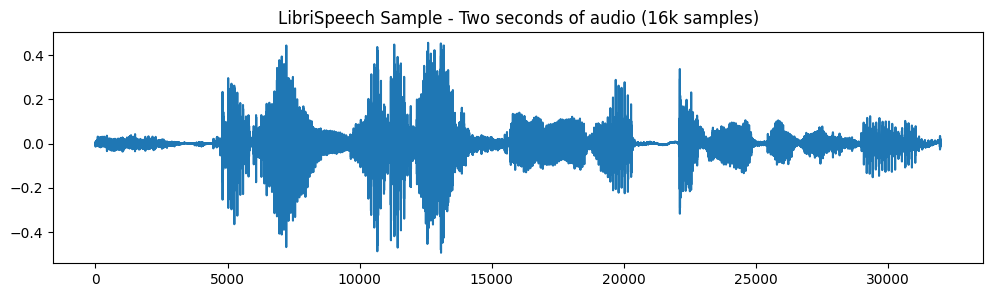

<Figure size 640x480 with 0 Axes>

In [6]:
libri_audio = libri_samples[1]['audio']['array'].squeeze()
libri_title = "LibriSpeech Sample - Two seconds of audio (16k samples)"
plot_audio(libri_audio, libri_title)

In [7]:
transcript = libri_samples[1]['text']
transcript

'THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF FLOWERS OF WHICH THEY HAD MADE A PLENTIFUL PROVISION TO GREET THE ARRIVAL OF THE YOUNG PRINCESS THE FRENCH IN RETURN INVITED THE ENGLISH TO A SUPPER WHICH WAS TO BE GIVEN THE NEXT DAY'

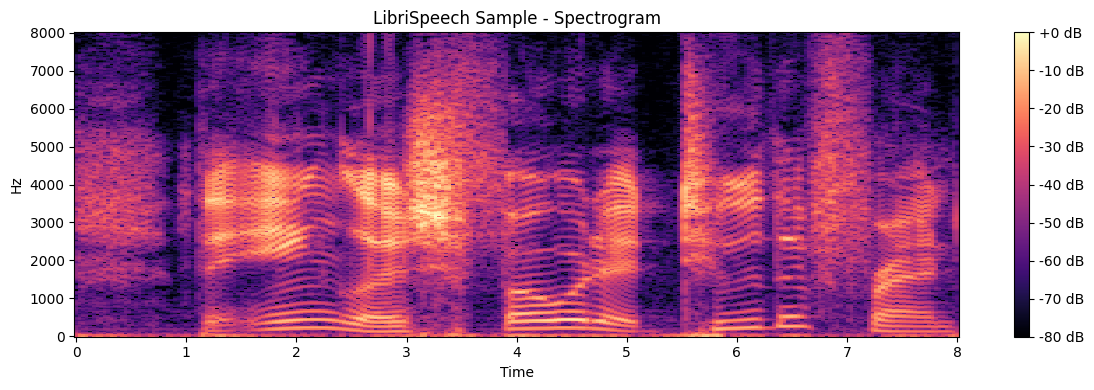

<Figure size 640x480 with 0 Axes>

In [8]:
libri_spectogram_title = "LibriSpeech Sample - Spectrogram"
plot_spectogram(libri_audio, libri_spectogram_title)

### Load Switchboard Dataset (Conversational Speech)

[Switchboard](https://catalog.ldc.upenn.edu/LDC97S62) is a speech telephone conversation dataset between strangers. The speaking style is spontaneous with interruptions in the normal flow of speech ("um", "uh"). You can learn more about Switchboard on the [HuggingFace datasets page](https://huggingface.co/datasets/openslr/librispeech_asr).

In [9]:
switchboard = load_dataset("hhoangphuoc/switchboard", split="test", streaming=True)

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/54 [00:00<?, ?it/s]

Let's explore a few samples in the Switchboard dataset:

In [10]:
switch_samples = []
for i, sample in enumerate(switchboard):
    if len(sample['transcript'].split()) > 10:
        switch_samples.append(sample)
    if len(switch_samples) >= 50:
        break

print("Switchboard Sample Transcripts:")
print("="*100)
for i, sample in enumerate(switch_samples):
    print(f"Switchboard Sample {i+1}: {sample['transcript']}")
    print("-"*100)

Switchboard Sample Transcripts:
Switchboard Sample 1: uhhuh if it is gonna cost that much i will do with what i already have right or some of the styles are kind of weird too so
----------------------------------------------------------------------------------------------------
Switchboard Sample 2: well my wife and i are right now saving for a trip to to england
----------------------------------------------------------------------------------------------------
Switchboard Sample 3: well we call it the s p c a it is the uh from an animal shelter uh he would come in there as a stray uh he is a pomeranian and sheltie cross uh
----------------------------------------------------------------------------------------------------
Switchboard Sample 4: uh oh well now i i guess i just pick out and read out of both of them what interests me there is an article about
----------------------------------------------------------------------------------------------------
Switchboard Sample 5: and the

Let's listen and plot a few of these samples:

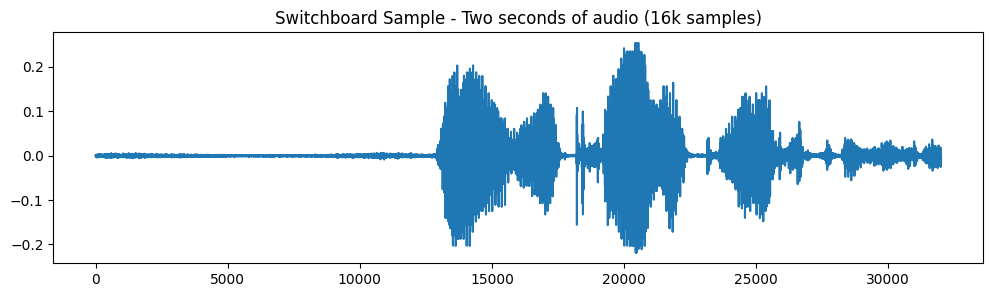

<Figure size 640x480 with 0 Axes>

In [11]:
switch_audio = switch_samples[2]['audio']['array'].squeeze()
switch_title = "Switchboard Sample - Two seconds of audio (16k samples)"
plot_audio(switch_audio, switch_title)

In [12]:
transcript = switch_samples[2]['transcript']
transcript

'well we call it the s p c a it is the uh from an animal shelter uh he would come in there as a stray uh he is a pomeranian and sheltie cross uh'

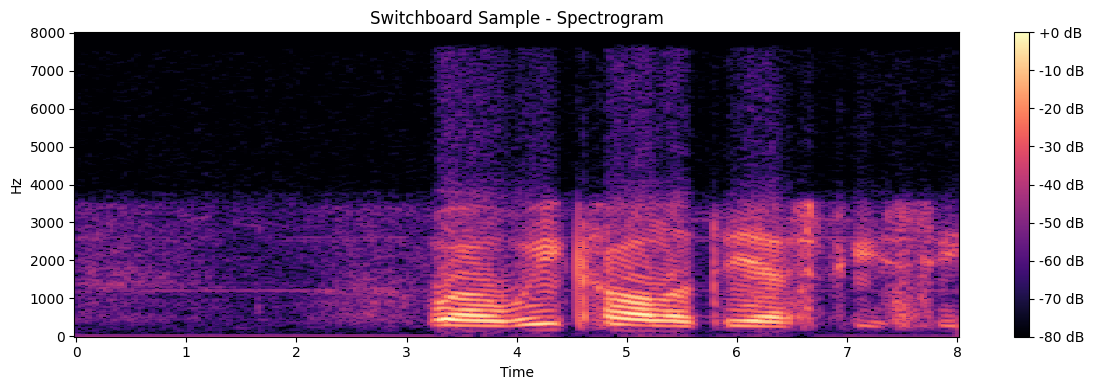

<Figure size 640x480 with 0 Axes>

In [13]:
switch_spectogram_title = "Switchboard Sample - Spectrogram"
plot_spectogram(switch_audio, switch_spectogram_title)

## Questions 1.1-1.2
1.1 Compare the spectrograms of LibriSpeech and Switchboard samples. What are some of the differences you can identify in frequency content, noise, and temporal patterns?

The LibriSpeech sample shows a wider and structured frequency range with patterns over time. The Switchboard sample has more noise, irregular energy distribution and less frequency dominant.

1.2 What acoustic differences did you observe in the datasets and how does this compare to the transcripts?

The Switchboard data sounds less clear and more conversational with background noise. LibriSpeech audio is crisp and articulate. Switchboard transcripts are conversational and have filler words like "uh" and incomplete sentences. LibriSpeech transcripts and grammatical.

## Question 1.3
1.3 Calculate the average utterance length for a few samples of conversational (Switchboard) vs read (Librispeech) speech. Which dataset tends to have longer utterances?

In [ ]:
def compare_average_length(libri_samples, switch_samples):
  """
  Computes and prints the average utterance length (in words)
  for Librispeech (read) vs Switchboard (conversational) samples .
  """
  def compare_average_length(libri_samples, switch_samples):
  def get_text_list(samples):
      if isinstance(samples, dict) and "text" in samples:
          texts = samples["text"]
          return texts if isinstance(texts, list) else [texts]
      return [s["text"] if isinstance(s, dict) and "text" in s else str(s) for s in samples]

  def average_length(text_list):
      lengths = [len(t.split()) for t in text_list if isinstance(t, str) and t.strip()]
      return round(sum(lengths) / len(lengths), 1) if lengths else 0

  switch_texts = get_text_list(switch_samples)
  libri_texts = get_text_list(libri_samples)

  print("Average conversational (switch_samples):", average_length(switch_texts))
  print("Average read (libri_samples):", average_length(libri_texts))

compare_average_length(libri_samples, switch_samples)


In [14]:
#@title show solution { display-mode: "form" }
def compare_average_length(libri_samples, switch_samples):
  def get_text_list(samples):
      if isinstance(samples, dict) and "text" in samples:
          texts = samples["text"]
          return texts if isinstance(texts, list) else [texts]
      return [s["text"] if isinstance(s, dict) and "text" in s else str(s) for s in samples]

  def average_length(text_list):
      lengths = [len(t.split()) for t in text_list if isinstance(t, str) and t.strip()]
      return round(sum(lengths) / len(lengths), 1) if lengths else 0

  switch_texts = get_text_list(switch_samples)
  libri_texts = get_text_list(libri_samples)

  print("Average conversational (switch_samples):", average_length(switch_texts))
  print("Average read (libri_samples):", average_length(libri_texts))

compare_average_length(libri_samples, switch_samples)



Average conversational (switch_samples): 41.2
Average read (libri_samples): 18.3


## Load Models

### Whisper

Whisper is a pre-trained model for automatic speech recognition (ASR)
published in [September 2022](https://openai.com/blog/whisper/) by the authors
Alec Radford et al. from OpenAI. Whisper is pre-trained on a vast quantity of
**labelled** audio-transcription data, 680,000 hours to be precise.

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

------------------------------------------------------------------------

\\({}^1\\) The name Whisper follows from the acronym “WSPSR”, which stands for “Web-scale Supervised Pre-training for Speech Recognition”.

#### Load Whisper Model for ASR

Set up environment for whisper and run unit test.


In [15]:
unit_test_sample_hf = torch.from_numpy(libri_samples[1]['audio']['array']).float().to('cuda')
display(Audio(unit_test_sample_hf.data.to('cpu'), rate=16000))


In [16]:
whisper_model = whisper.load_model("turbo").to('cuda')
with torch.no_grad():
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(unit_test_sample_hf), n_mels=whisper_model.dims.n_mels)
    options = whisper.DecodingOptions()
    result = whisper.decode(whisper_model, mel, options)
print(result.text)


100%|█████████████████████████████████████| 1.51G/1.51G [00:19<00:00, 83.2MiB/s]


the english forwarded to the french baskets of flowers of which they had made a plentiful provision to greet the arrival of the young princess the french in return invited the english to a supper which was to be given the next day


Run inference and compute word error rate for Whisper on Librispeech and Switchboard:

In [17]:
run_whisper_eval(whisper_model, librispeech, num_samples=100, data_set_desc="Librispeech")
run_whisper_eval(whisper_model, switchboard, num_samples=100, data_set_desc="Switchboard", text_field_name='transcript')

101it [00:47,  2.11it/s]


Whisper word error rate on Librispeech: 2.05%


101it [00:38,  2.63it/s]

Whisper word error rate on Switchboard: 50.74%


### Wav2Vec2

Wav2Vec2 [(Baevski et al., 2020)](https://arxiv.org/abs/2006.11477) is a model of self-supervised learning representations (SSLR) trained primarily on unlabeled English speech.

#### Load Wav2Vec2 for ASR
Set up environment for wav2vec2 fine-tuned for ASR:

In [18]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
wav2vec2_model = bundle.get_model().to('cuda')

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

unit_test_sample_hf = libri_samples[1]
decoder = GreedyCTCDecoder(labels=bundle.get_labels())

run_wav2vec2_inference(wav2vec2_model, decoder, unit_test_sample_hf, "unit test")


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


100%|██████████| 360M/360M [00:04<00:00, 92.1MB/s]


Results from sample from unit test.
Reference text: 'the english forwarded to the french baskets of flowers of which they had made a plentiful provision to greet the arrival of the young princess the french in return invited the english to a supper which was to be given the next day'
Result text: 'the english foted to the french baskets of flowers of which they had made a plentiful provision to greet the arrival of the young princess the french in return invited the english to a supper which was to be given the next day'


In [19]:
bundle = torchaudio.pipelines.HUBERT_ASR_LARGE
hubert_model = bundle.get_model().to('cuda')

Downloading: "https://download.pytorch.org/torchaudio/models/hubert_fairseq_large_ll60k_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/hubert_fairseq_large_ll60k_asr_ls960.pth


100%|██████████| 1.18G/1.18G [01:11<00:00, 17.7MB/s]


## Run Inference

Run inference and compute word error rate (WER) for fine-tuned wav2vec2 on LibriSpeech and Switchboard:

In [20]:
run_wav2vec2_eval(wav2vec2_model, decoder, librispeech, num_samples=100,
                      data_set_desc="Librispeech")

run_wav2vec2_eval(wav2vec2_model, decoder, switchboard, num_samples=100,
                      data_set_desc="Switchboard", text_field_name='transcript')

101it [00:05, 17.05it/s]


wav2vec2 word error rate on Librispeech: 3.32%


101it [00:04, 21.68it/s]                        

wav2vec2 word error rate on Switchboard: 92.52%


## Questions 1.4-1.7
1.4 What are the WER differences between LibriSpeech and Switchboard for each model?

The WER is much higher on the Switchboard dataset for both models. The LibriSpeech samples have much lower WER because audio is more cleaner.

1.5 Which model shows a larger performance degradation on conversational speech? Why might this be?

The Wav2Vec2 shows larger performance degradation on conversational speech. This is likely because Wav2Vec2 is trained on cleaner, read speech. It will struggle with overlapping, noisy inputs which are typical in Switchboard.

1.6 Why do ASR systems struggle with conversational speech compared to read speech? What can this tell us about the training data distribution?

Conversational speech is unstable, has more pauses, variable speaking speeds, fillers, background noise and muffled voices. Read speech is more stable, it is more consistent and controlled. The performance will be much better on these kinds of data. This makes us understand that training data is primarily clean and well articulated.

1.7 Which model architecture seems better suited for real-world applications?

The Whisper model architecture appears better suited for real-world applications. It has been trained on a diverse dataset that includes noisy and conversational audio,background sounds, and speaking styles more effectively than models trained only on clean data.




# Speech Recognition Tutorial Part 2 - Understanding ASR Model Performance Between Close-Talk vs. Far-Field Speech

This section will now move away from Conversational/Read Speech and move on to another topic: how audio is processed when the source is closer or further to the microphone.


This portion of the tutorial will explore the [Augmented Multiparty Interaction (AMI) dataset](https://link.springer.com/chapter/10.1007/11677482_3).

AMI is explained at the link above; TL;DR: it’s a dataset of meeting recordings captured by microphones positioned around a meeting room. The meeting transcripts are also provided, giving us paired audio–text data. This dataset is particularly interesting because it addresses a key question in ASR evaluation: how much does ASR quality depend on the speaker’s distance from the microphone? It provides a [very important benchmark for the ASR community](https://scholar.google.com/scholar?cites=15549805405547395378&as_sdt=20000005&sciodt=0,21&hl=en&oi=gsb) to test their models on "Close-talk"  and "Far-Field" performance, respectively.

The dataset is divided into two categories:
  - **Independent Headset Microphones** (IHM): In this partition, speakers wear head-mounted microphones that record their speech. This is the “close-talk” condition.

  - **Single Distant Microphone** (SDM): In this partition, the same meetings are captured with a single microphone placed at the center of the room. This is the “far-field” condition.



## Objectives
1. Load the [AMI dataset hosted on HuggingFace](https://huggingface.co/datasets/edinburghcstr/ami).
2. Compare utterances from the IHM and SDM partitions to get a sense of how the speech quality changes.
3. Run inference with the two ASR models; namely, OpenAI's [Whisper](https://openai.com/index/whisper/) and Facebook's [Wav2Vec2](https://ai.meta.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/).
4. Compare model performance between close-talk and far-field speech.
5. Understand the impact that different types of speech can have on model performance.

## Load and explore AMI Dataset for both IHM and SDM

**Note**: The version of the AMI dataset hosted on Hugging Face is outdated and requires the user allow for "custom code" to be run. The code below will prompt the user to input "y" in order to continue.


In [21]:
ami_ihm = load_dataset("edinburghcstr/ami", 'ihm', split="train", streaming=True)
ami_sdm = load_dataset("edinburghcstr/ami", 'sdm', split="train", streaming=True)

README.md: 0.00B [00:00, ?B/s]

ami.py: 0.00B [00:00, ?B/s]

The repository for edinburghcstr/ami contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/edinburghcstr/ami.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Let's select an example from IHM and see what it sounds like.

In [22]:
ami_ihm_sample = None
ihm_sample_id = "AMI_EN2001a_H04_MEO069_0330297_0330718"
for sample in ami_ihm:
  if sample['audio_id'] == ihm_sample_id:
    ami_ihm_sample = sample
    print(f"Found sample with audio_id '{ihm_sample_id}' and transcript '{ami_ihm_sample['text']}' in interval [{ami_ihm_sample['begin_time']},{ami_ihm_sample['end_time']}]")
    break

Found sample with audio_id 'AMI_EN2001a_H04_MEO069_0330297_0330718' and transcript 'IF YOU IF YOU S. S. H. AND THEY HAVE THIS BIG WARNING ABOUT DOING NOTHING AT ALL IN THE GATEWAY MACHINE' in interval [3302.969970703125,3307.179931640625]


Now we find the corresponding SDM sample(s) where the audio timestamps overlap with the above sample.

In [23]:
# NOTE: We provide a set of sdm samples to inspect
# based on the audio_id '' provided above. To try other pairs, feel free to
# change the id in the loop above and here. This is a good way to get familiar
# with the dataset viewer at Hugging Face:
# https://huggingface.co/datasets/edinburghcstr/ami/viewer
ami_sdm_sample = None
sdm_sample_id = "AMI_EN2001a_sdm_MEO069_0330297_0330718"

for sample in ami_sdm:
  if sample['audio_id'] == sdm_sample_id:
    ami_sdm_sample = sample
    print(f"Found sample with audio_id '{sdm_sample_id}' and transcript '{ami_sdm_sample['text']}' in interval [{ami_sdm_sample['begin_time']},{ami_sdm_sample['end_time']}]")
    break

Found sample with audio_id 'AMI_EN2001a_sdm_MEO069_0330297_0330718' and transcript 'IF YOU IF YOU S. S. H. AND THEY HAVE THIS BIG WARNING ABOUT DOING NOTHING AT ALL IN THE GATEWAY MACHINE' in interval [3302.969970703125,3307.179931640625]


Keep in mind that for this pair, both samples have the same transcript but various differences in the audio.

Let's listen and plot both of these samples and see if we can hear and/or spot  differences:

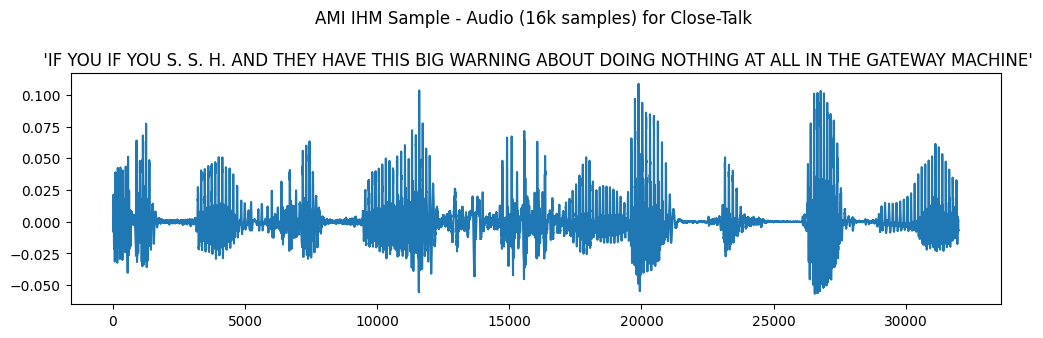

<Figure size 640x480 with 0 Axes>

In [24]:


ami_ihm_audio = ami_ihm_sample['audio']['array'].squeeze()
ami_ihm_title = f"AMI IHM Sample - Audio (16k samples) for Close-Talk \n\n '{ami_ihm_sample['text']}'"
plot_audio(ami_ihm_audio, ami_ihm_title)


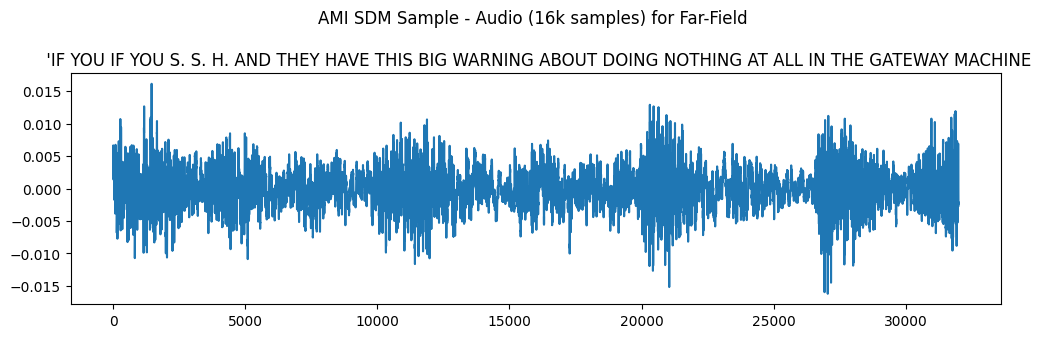

<Figure size 640x480 with 0 Axes>

In [25]:
ami_sdm_audio = ami_sdm_sample['audio']['array'].squeeze()
ami_sdm_title = f"AMI SDM Sample - Audio (16k samples) for Far-Field \n\n '{ami_sdm_sample['text']}"
plot_audio(ami_sdm_audio, ami_sdm_title)


## Questions 2.1-2.2

2.1. Compare the visualizations of the IHM and SDM audio samples. What are some of the differences you can identify?

The IHM sample shows much stronger and sharper spikes than the SDM sample. This is mainly due to the placement of audio capturing source. The microphone is closer to speaker's mouth, minimising environmental noise. The SDM sample is much more reverberation, background noise.

2.2. What acoustic differences did you observe in the datasets and how does this compare to the transcripts?

The IHM sample is much more clearer and more intelligible. SDM recordings have room echo and environmental noise. IHM transcripts are more accurate and complete, wheras SDM transcripts are not.

Now we can use the audio examples above to examine the Spectograms.

Let's again try to see if we can spot differences between close-talk and far-field speech by visually inspecting these images.

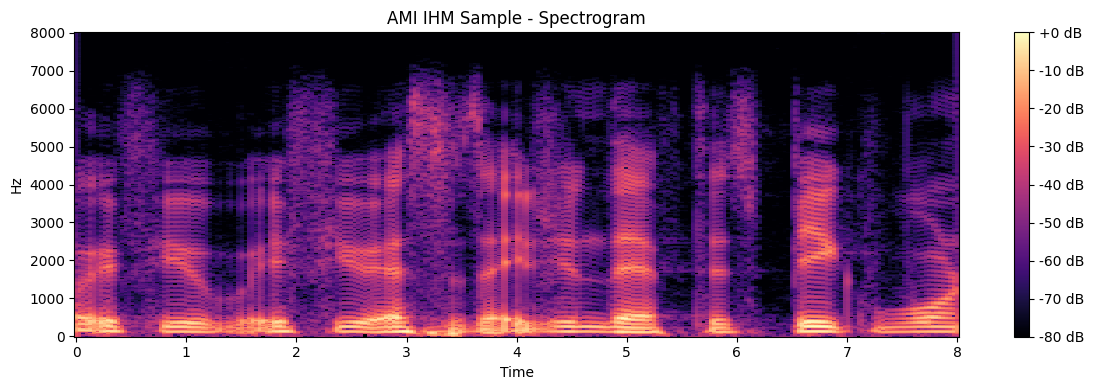

<Figure size 640x480 with 0 Axes>

In [26]:
ami_ihm_spectogram_title = 'AMI IHM Sample - Spectrogram'
plot_spectogram(ami_ihm_audio, ami_ihm_spectogram_title)

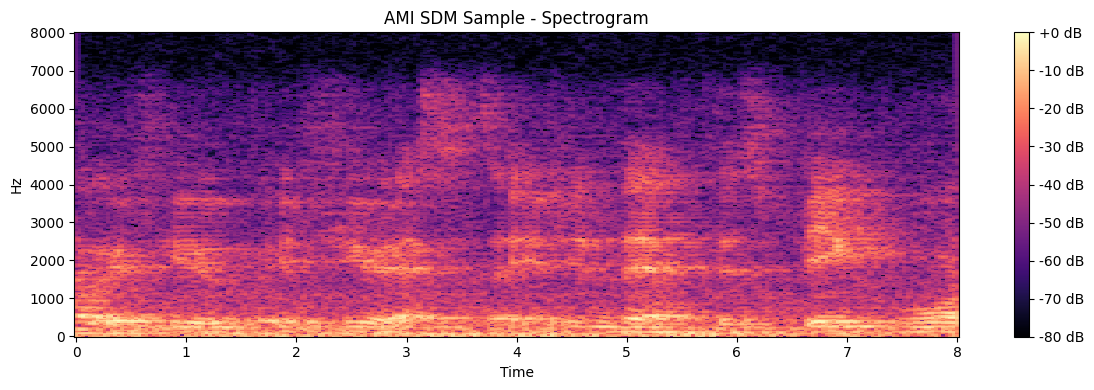

<Figure size 640x480 with 0 Axes>

In [27]:
ami_sdm_spectogram_title = 'AMI SDM Sample - Spectrogram'
plot_spectogram(ami_sdm_audio, ami_sdm_spectogram_title)

## Question 2.3
2.3. Describe the differences you can see in the spectograms above for the IHM and SDM audio samples.

The difference in spectrograms in more or less the same. The IHM spectrogram shows clear, concentrated regions with strong energy indicating clear speech. SDM spectrogram is blurred.

## Load AMI Test Sets and Run Evals

In [28]:
ami_ihm_test = load_dataset("edinburghcstr/ami", 'ihm', split="test", streaming=True)
run_whisper_eval(whisper_model, data_set=ami_ihm_test, num_samples=100, data_set_desc="AMI IHM")

101it [00:27,  3.69it/s]

Whisper word error rate on AMI IHM: 34.55%


In [29]:
ami_sdm_test = load_dataset("edinburghcstr/ami", 'sdm', split="test", streaming=True)
run_whisper_eval(whisper_model, data_set=ami_sdm_test, num_samples=100, data_set_desc="AMI SDM")

101it [00:27,  3.65it/s]

Whisper word error rate on AMI SDM: 86.23%


## Question 2.4
2.4. Based on the reported WER differences between IHM and SDM, which task is "easier" and which is "harder"? Are these what you expected? Why or why not?

IHM is much easier than SDM. I expected a higher word error rate for SDM but not by this margin. My intuition was that the presence of ambient noise in the samples would make it hard for the Whisper model to capture words accurately.

Wow! Quite a difference in WER. Let's examine the output from the whisper model on our example utterances from before.

In the helper functions provided at the top of this colab, we provided a `run_whisper_eval` method. To examine the output for our example utterances, we should implement a `run_whisper_inference` method to do one shot inference on a given sample.

Try to implement this yourself below!

In [ ]:
def run_whisper_inference(whisper_model, sample, sample_desc,
                          text_field_name='text'):
  """
  Given an instance of a Whisper ASR model, runs inference on a single provided
  sample.
  """
  english_normalizer = EnglishTextNormalizer()
  with torch.no_grad():
    audio = torch.from_numpy(sample['audio']['array']).float().to('cuda')
    sr = sample['audio']['sampling_rate']
    assert sr == 16000
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio),
                                      n_mels=whisper_model.dims.n_mels)
    options = whisper.DecodingOptions()
    result = english_normalizer(whisper.decode(whisper_model, mel,
                                               options).text)
    reference = english_normalizer(text_field_name)
  print(f"Results from sample from {sample_desc}.")
  print(f"Reference text: '{reference}'")
  print(f"Result text: '{result}'")

In [30]:
#@title show solution { display-mode: "form" }
def run_whisper_inference(whisper_model, sample, sample_desc,
                          text_field_name='text'):
  """
  Given an instance of a Whisper ASR model, runs inference on a single provided
  sample.
  """
  english_normalizer = EnglishTextNormalizer()
  with torch.no_grad():
    audio = torch.from_numpy(sample['audio']['array']).float().to('cuda')
    sr = sample['audio']['sampling_rate']
    assert sr == 16000
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio),
                                      n_mels=whisper_model.dims.n_mels)
    options = whisper.DecodingOptions()
    result = english_normalizer(whisper.decode(whisper_model, mel,
                                               options).text)
    reference = english_normalizer(text_field_name)
  print(f"Results from sample from {sample_desc}.")
  print(f"Reference text: '{reference}'")
  print(f"Result text: '{result}'")

In [31]:
run_whisper_inference(whisper_model, sample=ami_ihm_sample, sample_desc="AMI IHM")

Results from sample from AMI IHM.
Reference text: 'text'
Result text: 'if you ss agent they have this big warning about doing nothing at all in the gateway machine'


In [32]:
run_whisper_inference(whisper_model, sample=ami_sdm_sample, sample_desc="AMI SDM")

Results from sample from AMI SDM.
Reference text: 'text'
Result text: 'if you have this big warning about doing nothing at all in the gate'


## Question 2.5
2.5. Speculate on why there is a discrepancy on the above output text for audios with the same reference transcript. Refer to the audio, waveform plots, and spectograms above to get a better sense of what is happening.

The discrepancy arises because SDM audio is recorded from a distance, which causes signal loss, background noise and reverberation. This causes phonemes harder for the model to recognise.As the IHM audio is much clear and has sharper features, the model is able to capture words correctly.

## Inference

Now Run Evals On AMI Using Wav2Vec2

In [33]:
run_wav2vec2_eval(wav2vec2_model, decoder, ami_ihm_test, num_samples=100, data_set_desc="AMI IHM")

101it [00:04, 23.73it/s]                        

wav2vec2 word error rate on AMI IHM: 77.04%


In [34]:
run_wav2vec2_eval(wav2vec2_model, decoder, ami_sdm_test, num_samples=100, data_set_desc="AMI SDM")

101it [00:03, 26.59it/s]                        

wav2vec2 word error rate on AMI SDM: 125.18%


Note here that we see a very large WER difference in both the IHM and SDM test sets for this ASR model compared to the Whisper model. Let’s look again at the outputs of our earlier example utterances, this time using Wav2Vec 2.0.

In [35]:
run_wav2vec2_inference(wav2vec2_model, decoder, sample=ami_ihm_sample, sample_desc="AMI IHM")

Results from sample from AMI IHM.
Reference text: 'if you if you s s h and they have this big warning about doing nothing at all in the gateway machine'
Result text: 'if you if you es his agent theve to speak warning about doing nothing at all in the gateway machine'


In [36]:
run_wav2vec2_inference(wav2vec2_model, decoder, sample=ami_sdm_sample, sample_desc="AMI SDM")

Results from sample from AMI SDM.
Reference text: 'if you if you s s h and they have this big warning about doing nothing at all in the gateway machine'
Result text: 'you if you es staten that tis beak warning about toe notin i ong in tean'


## Questions 2.6-2.7

2.6. We established that wav2vec2 does much worse than whisper here. Why might this be the case?
**Hint:** Consider the data the wav2vec2 model we are using was pre-trained on: https://docs.pytorch.org/audio/stable/generated/torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.html
What did we learn about performance on Conversational v.s. Read ASR tasks?

Wav2Vec2 performs worde because it was pre trained on LibriSpeech which is clean and read speech and not on noisy or conversational data. So it struggles with real-world variability.

2.7. Do the results on wav2vec2 still show that one of these test sets (IHM or SDM) represents an "easier" task than the other?

Yes. Even for Wav2Vec2, IHM remains easier task and SDM is harder. The closer, cleaner IHM audio produces lower WER than noisy, distant SDM recordings.

# Speech Recognition Tutorial Part 3 - Whisper For Multilingual ASR

In this section, we present a step-by-step guide on how to use Whisper
for any multilingual ASR dataset using Hugging Face 🤗 Transformers.

Recall that Whisper was pretrained on a vast corpus—680,000 hours, to be precise—of labeled audio–text pairs.
This is an order of magnitude more data than the un-labelled audio data used
to train Wav2Vec 2.0 (60,000 hours). What is more, 117,000 hours of this
pre-training data is multilingual ASR data. This results in checkpoints
that can be applied to over 96 languages, many of which are considered
_low-resource_.

When scaled to 680,000 hours of labelled pre-training data, Whisper models
demonstrate a strong ability to generalise to many datasets and domains.
The pre-trained checkpoints achieve competitive results to state-of-the-art
ASR systems, with near 3% word error rate (WER) on the test-clean subset of
LibriSpeech ASR and a new state-of-the-art on TED-LIUM with 4.7% WER (_c.f._
Table 8 of the [Whisper paper](https://cdn.openai.com/papers/whisper.pdf)).

The Whisper checkpoints come in five configurations of varying model sizes.
The smallest four are trained on either English-only or multilingual data.
The largest checkpoints are multilingual only. All 11 of the pre-trained checkpoints
are available on the [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper). The
checkpoints are summarised in the following table with links to the models on the Hub:

| Size     | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


For demonstration purposes, we'll use the multilingual version of the
[`"small"`](https://huggingface.co/openai/whisper-small) checkpoint with 244M params (~= 1GB).
As for our data, we'll train and evaluate our system on a low-resource language
taken from the [Fleurs](https://huggingface.co/papers/2205.12446)
dataset.

## Objectives

1. Load multilingual FLEURS dataset and examine data properties.
2. Use Whisper for multilingual speech recognition of both English and another language.
3. Compare statistics and performance across languages.

## Setup

We'll employ several popular Python packages to fine-tune the Whisper model.
We'll use `datasets[audio]` to download and prepare our training data, alongside
`transformers` and `accelerate` to load and train our Whisper model.
We'll also require the `soundfile` package to pre-process audio files,
`evaluate` and `jiwer` to assess the performance of our model. Finally, we'll use `gradio` to build a
flashy demo of our fine-tuned model.

In [37]:
# Install neccessary packages - some of these were already installed
# Only install the new ones....
# !pip install --upgrade --quiet evaluate tensorboard gradio
!pip install --upgrade --quiet evaluate gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00


## Load and explore FLEURS datasets

Using 🤗 datasets, downloading and preparing data is extremely simple.
We can download and prepare the FLEURS splits in just one line of code.

We will compare the model perfomance on high-resource languages, such as **English** and relatively Low-resource languages such as **Hindi**.

### Prepare the English data

**Note**: data download will take 2-3 minutes.

In [38]:
from datasets import load_dataset, DatasetDict, Audio

LANG_CFG = "en_us"   # or "ka_ge", "en_us"
ds_en = DatasetDict({
    "dev": load_dataset("google/fleurs", LANG_CFG, split="validation", trust_remote_code=True, streaming=True),
    "test":  load_dataset("google/fleurs", LANG_CFG, split="test", trust_remote_code=True, streaming=True),
                                                                  })
# Use Audio(decode=False) to load only metadata (not waveforms); faster for stats

README.md: 0.00B [00:00, ?B/s]

fleurs.py: 0.00B [00:00, ?B/s]

In [39]:
ds_en_nod = DatasetDict({k: v.cast_column("audio", Audio(decode=False)) for k, v in ds_en.items()})

In [40]:
print(ds_en_nod)

DatasetDict({
    dev: IterableDataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_shards: 1
    })
    test: IterableDataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_shards: 1
    })
})


### Exploratory Data Analysis (EDA)

This section presents an initial step to investigate and understand the data fields, and the data statistics like average clip duration, min/max duration, and basic transcript metrics (characters and words).



In [41]:
# Let's print the first example to inspect the data:

from collections import Counter
import numpy as np

split = "dev"
sample = 0
try:
    SR = ds_en[split[0]].features["audio"].sampling_rate
except Exception:
    SR = 16000  # fallback
print(f"Sampling rate: {SR} Hz\n")

try:
  ex = ds_en_nod[split][sample]
except(TypeError, NotImplementedError):
   ex = next(iter(ds_en_nod[split]))
print(f"Sample {sample} from {split} split:")

for k, v in ex.items():
    if k == "audio" and isinstance(v, dict):
        print(f"\t{k}:")
        for kk in ("path", "sampling_rate"):
            if kk in v:
                print(f"\t  {kk}: {v[kk]}")
    else:
        print(f"\t{k}: {v}")

Sampling rate: 16000 Hz

Sample 0 from dev split:
	id: 1548
	num_samples: 104640
	path: None
	audio:
	  path: dev/10010138729160973689.wav
	transcription: when you call someone who is thousands of miles away you are using a satellite
	raw_transcription: When you call someone who is thousands of miles away, you are using a satellite.
	gender: 0
	lang_id: 19
	language: English
	lang_group_id: 0


## Dataset statistics

Compute statistics for the dev and test subsets, including the mean, maximum, and minimum values of both audio duration and transcription length.

In [42]:
#@title show solution { display-mode: "form" }
import numpy as np
from collections import Counter

splits = [s for s in ["dev", "test"] if s in ds_en_nod]

def dur_hours(ex):
    # duration in hours using lightweight num_samples
    return ex["num_samples"] / SR / 3600.0

def text_lens(ex):
    t = ex.get("transcription") or ""
    return {"chars": len(t), "words": len(t.split())}

def summarize_split(name, dset):
    try:
      n = len(dset)
    except TypeError:
      n = sum(1 for _ in dset)

    # Durations (in hours; convert to seconds for readability)
    try:
      durs = dset.map(lambda ex: {"_h": dur_hours(ex)}, remove_columns=dset.column_names).to_list()
    except AttributeError:
      durs = [{"_h": dur_hours(ex)} for ex in dset]
    durs = np.array([x["_h"] for x in durs], dtype=float)        # hours
    dur_mean_s = durs.mean() * 3600.0
    dur_min_s  = durs.min()  * 3600.0
    dur_max_s  = durs.max()  * 3600.0

    # Text lengths
    try:
      tl    = dset.map(text_lens, remove_columns=[]).to_list()
    except AttributeError:
      tl = [text_lens(ex) for ex in dset]
    chars = np.array([x["chars"] for x in tl], dtype=float)
    words = np.array([x["words"] for x in tl], dtype=float)

    # Gender / Language counts (kept as in your code)
    genders = [ex.get("gender") for ex in dset]
    langs   = [ex.get("language") for ex in dset]
    g_cnt = Counter(genders)
    l_cnt = Counter(langs)

    # Print
    print(f"=== {name.upper()} ===")
    print(f"Examples: {n:,}")
    print(f"Total duration: {durs.sum():.2f} h | Avg: {dur_mean_s:.1f} s | Min/Max: {dur_min_s:.1f} / {dur_max_s:.1f} s")

    print(f"Chars per utt — mean: {chars.mean():.1f}, min/max: {chars.min():.0f} / {chars.max():.0f}")
    print(f"Words per utt — mean: {words.mean():.1f}, min/max: {words.min():.0f} / {words.max():.0f}")

# Usage
for split in splits:
    summarize_split(split, ds_en_nod[split])


=== DEV ===
Examples: 394
Total duration: 1.05 h | Avg: 9.6 s | Min/Max: 2.7 / 31.7 s
Chars per utt — mean: 122.9, min/max: 33 / 265
Words per utt — mean: 20.7, min/max: 8 / 46
=== TEST ===
Examples: 647
Total duration: 1.77 h | Avg: 9.9 s | Min/Max: 3.6 / 29.3 s
Chars per utt — mean: 129.8, min/max: 42 / 362
Words per utt — mean: 22.2, min/max: 7 / 52


## Question 3.1

What is the mean duration of audio files in the English dev set?

The mean duration of audio files in English dev set is 9.6s

## Visualize audio

Visualize the wavform and play the audio.

Use `matplotlib` to visualize the wavform and `Audio`, `display` from `IPython.display` to play the audio

id: 1548
lang: 19, gender: 0
duration: 6.54 s
text: when you call someone who is thousands of miles away you are using a satellite


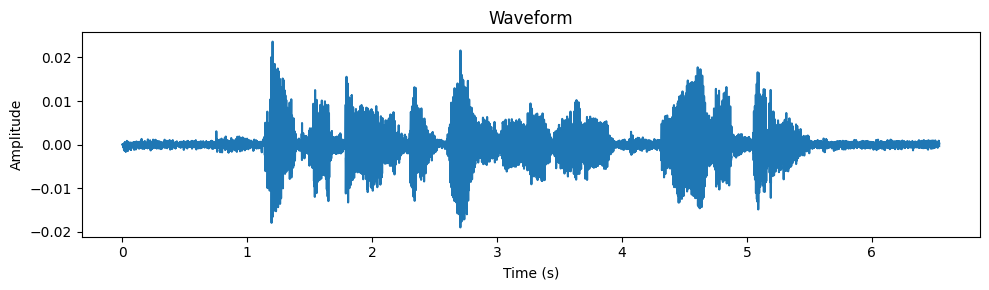

In [43]:
from datasets import Dataset, DatasetDict
from datasets.features import Audio
import itertools

# --- choose a split & index ---
SPLIT  = "dev"   # or "validation", "test"
INDEX  = 0         # any example you want

# Convert only the needed split, and only enough rows to cover INDEX
# Decode only what you need (keeps memory low)
ds_en_dec = ds_en[SPLIT].cast_column("audio", Audio(sampling_rate=SR, decode=True))

try:
    ex = next(itertools.islice(ds_en_dec, INDEX, INDEX + 1))
except StopIteration:
    print(f"Error: Index {INDEX} is out of bounds for the dataset.")
    raise

wav = ex["audio"]["array"]             # numpy array
text = ex.get("normalized_transcription") or ex.get("transcription") or ex.get("raw_transcription") or ""

print(f"id: {ex.get('id')}")
print(f"lang: {ex.get('lang_id')}, gender: {ex.get('gender')}")
print(f"duration: {wav.shape[-1] / SR:.2f} s")
print("text:", text)

# --- 1) play audio ---
from IPython.display import Audio as IPythonAudio, display
display(IPythonAudio(wav, rate=SR))

# --- 2) visualize waveform ---
import numpy as np
import matplotlib.pyplot as plt

y = wav
t = np.arange(y.shape[-1]) / SR

plt.figure(figsize=(10, 3))
plt.plot(t, y)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.tight_layout()
plt.show()

Next we visualize the spectrogram of the audio

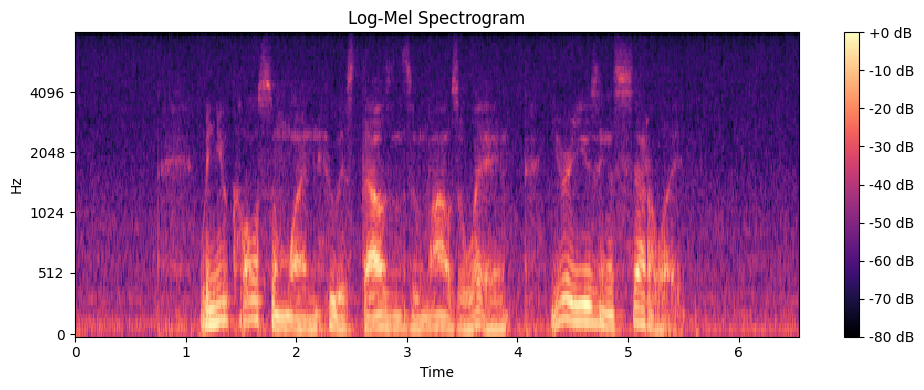

In [44]:
import librosa, librosa.display
import matplotlib.pyplot as plt

S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=80, n_fft=1024, hop_length=160, win_length=400)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=SR, hop_length=160, x_axis="time", y_axis="mel")
plt.title("Log-Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()


## Low-resource dataset


Now repeat for a low resource language like Georgian.
You can select other languages as well

Other possible languages for selection: {"af_za": "Afrikaans", "am_et": "Amharic", "ar_eg": "Arabic", "as_in": "Assamese", "az_az": "Azerbaijani", "be_by": "Belarusian", "bg_bg": "Bulgarian", "bn_in": "Bengali", "bs_ba": "Bosnian", "ca_es": "Catalan", "cmn_hans_cn": "Chinese", "cs_cz": "Czech", "cy_gb": "Welsh", "da_dk": "Danish", "de_de": "German", "el_gr": "Greek", "en_us": "English", "es_419": "Spanish", "et_ee": "Estonian", "fa_ir": "Persian", "fi_fi": "Finnish", "fil_ph": "Tagalog", "fr_fr": "French", "gl_es": "Galician", "gu_in": "Gujarati", "ha_ng": "Hausa", "he_il": "Hebrew", "hi_in": "Hindi", "hr_hr": "Croatian", "hu_hu": "Hungarian", "hy_am": "Armenian", "id_id": "Indonesian", "is_is": "Icelandic", "it_it": "Italian", "ja_jp": "Japanese", "jv_id": "Javanese", "ka_ge": "Georgian", "kk_kz": "Kazakh", "km_kh": "Khmer", "kn_in": "Kannada", "ko_kr": "Korean", "lb_lu": "Luxembourgish", "ln_cd": "Lingala", "lo_la": "Lao", "lt_lt": "Lithuanian", "lv_lv": "Latvian", "mi_nz": "Maori", "mk_mk": "Macedonian", "ml_in": "Malayalam", "mn_mn": "Mongolian", "mr_in": "Marathi", "ms_my": "Malay", "mt_mt": "Maltese", "my_mm": "Myanmar", "nb_no": "Norwegian", "ne_np": "Nepali", "nl_nl": "Dutch", "oc_fr": "Occitan", "pa_in": "Punjabi", "pl_pl": "Polish", "ps_af": "Pashto", "pt_br": "Portuguese", "ro_ro": "Romanian", "ru_ru": "Russian", "sd_in": "Sindhi", "sk_sk": "Slovak", "sl_si": "Slovenian", "sn_zw": "Shona", "so_so": "Somali", "sr_rs": "Serbian", "sv_se": "Swedish", "sw_ke": "Swahili", "ta_in": "Tamil", "te_in": "Telugu", "tg_tj": "Tajik", "th_th": "Thai", "tr_tr": "Turkish", "uk_ua": "Ukrainian", "ur_pk": "Urdu", "uz_uz": "Uzbek", "vi_vn": "Vietnamese", "yo_ng": "Yoruba"}

**Note**: data download will take 2-3 minutes.

In [45]:

#@title show solution { display-mode: "form" }
# Georgian example
LANG_CFG = "ka_ge"   # or "ka_ge", "en_us"
ds_ka = DatasetDict({
    # "train": load_dataset("google/fleurs", LANG_CFG, split="train"),
    "dev": load_dataset("google/fleurs", LANG_CFG, split="validation", trust_remote_code=True, streaming=True),
    "test":  load_dataset("google/fleurs", LANG_CFG, split="test", trust_remote_code=True, streaming=True),
})

splits = [s for s in ["dev", "test"] if s in ds_ka]
# Try to read sampling rate from the Audio feature; fallback to 16k if missing.
try:
    SR = ds_ka[splits[0]].features["audio"].sampling_rate
except Exception:
    SR = 16000  # fallback
print(f"Sampling rate: {SR} Hz\n")

sample = 0
print(f"Sample {sample} from training data:")
# ex = ds_ka['dev'][sample]
ex = next(iter(ds_ka['dev']))
for k, v in ex.items():
    # Make the audio field concise
    if k == "audio" and isinstance(v, dict):
        print(f"\t{k}:")
        for kk in ("path", "sampling_rate"):
            if kk in v:
                print(f"\t  {kk}: {v[kk]}")
    else:
        print(f"\t{k}: {v}")

# Usage
for split in splits:
    summarize_split(split, ds_ka[split])

Sampling rate: 16000 Hz

Sample 0 from training data:
	id: 1529
	num_samples: 243840
	path: None
	audio:
	  path: dev/10027356231711165633.wav
	  sampling_rate: 16000
	transcription: ring-ის აღმასრულებელმა დირექტორმა ჯეიმი სიმონოვმა მანამდე აღნიშნა რომ მან კომპანია ჩამოაყალიბა მაშინ როდესაც ვერ გაიგე ავტოფარეხში გაკეთებული მაღაზიიდან მომავალი ზარის ხმა
	raw_transcription: Ring-ის აღმასრულებელმა დირექტორმა, ჯეიმი სიმონოვმა მანამდე აღნიშნა, რომ მან კომპანია ჩამოაყალიბა მაშინ, როდესაც ვერ გაიგე ავტოფარეხში გაკეთებული მაღაზიიდან მომავალი ზარის ხმა.
	gender: 1
	lang_id: 42
	language: Georgian
	lang_group_id: 1
=== DEV ===
Examples: 409
Total duration: 1.22 h | Avg: 10.7 s | Min/Max: 4.1 / 32.2 s
Chars per utt — mean: 130.6, min/max: 49 / 345
Words per utt — mean: 15.9, min/max: 5 / 42
=== TEST ===
Examples: 979
Total duration: 3.07 h | Avg: 11.3 s | Min/Max: 3.6 / 33.2 s
Chars per utt — mean: 140.3, min/max: 43 / 364
Words per utt — mean: 17.2, min/max: 5 / 45


## Question 3.2

What is the mean duration of audio files in the Georgian dev set?

The meain duration of audio files in Georgian dev set is 10.7s

## Load Whisper model and FeatureExtractor

The ASR pipeline can be de-composed into three stages:

1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format

In 🤗 Transformers, the Whisper model has an associated feature extractor and tokenizer,
called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)
and [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)
respectively.

We'll go through details for setting-up the feature extractor and tokenizer one-by-one!

The Whisper feature extractor performs two operations:
1. Pads / truncates the audio inputs to 30s: any audio inputs shorter than 30s are padded to 30s with silence (zeros), and those longer that 30s are truncated to 30s
2. Converts the audio inputs to _log-Mel spectrogram_ input features, a visual representation of the audio and the form of the input expected by the Whisper model

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

We'll load the feature extractor from the pre-trained checkpoint with the default values:

In [46]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json: 0.00B [00:00, ?B/s]

### Load WhisperTokenizer

The Whisper model outputs a sequence of _token ids_. The tokenizer maps each of these token ids to their corresponding text string. For Hindi, we can load the pre-trained tokenizer and use it for fine-tuning without any further modifications. We simply have to
specify the target language and the task. These arguments inform the
tokenizer to prefix the language and task tokens to the start of encoded
label sequences:

In [47]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

### Create A WhisperProcessor

To simplify using the feature extractor and tokenizer, we can _wrap_
both into a single `WhisperProcessor` class. This processor object
inherits from the `WhisperFeatureExtractor` and `WhisperProcessor`,
and can be used on the audio inputs and model predictions as required.
In doing so, we only need to keep track of two objects during training:
the `processor` and the `model`:

In [48]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small")

We can verify that the tokenizer correctly encodes the characters by encoding and decoding the first sample of the Fleurs dataset. When encoding the transcriptions, the tokenizer appends 'special tokens' to the start and end of the sequence, including the start/end of transcript tokens, the language token and the task tokens (as specified by the arguments in the previous step). When decoding the label ids, we have the option of 'skipping' these special tokens, allowing us to return a string in the original input form:

In [49]:
ex = next(iter(ds_ka["dev"]))
input_str = ex["transcription"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 ring-ის აღმასრულებელმა დირექტორმა ჯეიმი სიმონოვმა მანამდე აღნიშნა რომ მან კომპანია ჩამოაყალიბა მაშინ როდესაც ვერ გაიგე ავტოფარეხში გაკეთებული მაღაზიიდან მომავალი ზარის ხმა
Decoded w/ special:    <|startoftranscript|><|notimestamps|>ring-ის აღმასრულებელმა დირექტორმა ჯეიმი სიმონოვმა მანამდე აღნიშნა რომ მან კომპანია ჩამოაყალიბა მაშინ როდესაც ვერ გაიგე ავტოფარეხში გაკეთებული მაღაზიიდან მომავალი ზარის ხმა<|endoftext|>
Decoded w/out special: ring-ის აღმასრულებელმა დირექტორმა ჯეიმი სიმონოვმა მანამდე აღნიშნა რომ მან კომპანია ჩამოაყალიბა მაშინ როდესაც ვერ გაიგე ავტოფარეხში გაკეთებული მაღაზიიდან მომავალი ზარის ხმა
Are equal:             True


### Load Pretrained Whisper Checkpoint

We'll start from the pre-trained Whisper `small` checkpoint,
the weights for which we need to load from the Hugging Face Hub. Again, this
is trivial through use of 🤗 Transformers!

In [50]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [51]:
print(f"Total number of model parameters: {sum(p.numel() for p in model.parameters()):,}")

Total number of model parameters: 241,734,912


## Inference


- **Evaluation Metrics:**  
  During evaluation, we use the **Word Error Rate [WER](https://blog.kensho.com/word-error-rate-primer-a5808dcf4751)** as the primary metric to assess model performance.  
  WER measures the difference between predicted and reference transcriptions in terms of **substitutions**, **deletions**, and **insertions**.  
  To compute WER, we use the [**jiwer**](https://jitsi.github.io/jiwer/usage/) library, which provides convenient tools for calculating and analyzing transcription errors.

We can disable the automatic language detection task performed during inference, and force the model to generate in Hindi. To do so, we set the [langauge](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.language)
and [task](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
arguments to the generation config. We'll also set any [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)
to None, since this was the legacy way of setting the language and
task arguments:

Now that we've fine-tuned our model we can build a demo to show
off its ASR capabilities! We'll make use of 🤗 Transformers
`pipeline`, which will take care of the entire ASR pipeline,
right from pre-processing the audio inputs to decoding the
model predictions.

Running the example below will generate a Gradio demo where we
can record speech through the microphone of our computer and input it to
our fine-tuned Whisper model to transcribe the corresponding text:

In [52]:
import torch
# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Try using Whisper to recognize the audio segment we displayed before, setting the language explicitly.

In [53]:
import torch

model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="english", task="transcribe")

# Load an audio dataset (or your own audio file)
SPLIT = 'dev'
INDEX = 0

ds_en_dec = ds_en[SPLIT].cast_column("audio", Audio(sampling_rate=SR, decode=True))

try:
    ex = next(itertools.islice(ds_en_dec, INDEX, INDEX + 1))
except StopIteration:
    print(f"Error: Index {INDEX} is out of bounds for the dataset.")
    raise

sample_audio = ex["audio"]   # Example: using a sample from a dataset

ref_transcription = ex["transcription"]
print(f"Ref: {ref_transcription}")
input_features = processor(sample_audio["array"], sampling_rate=sample_audio["sampling_rate"], return_tensors="pt").input_features

# Move input features to GPU if available
if torch.cuda.is_available():
    input_features = input_features.to("cuda")

# generate token ids
predicted_ids = model.generate(input_features)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(f"Pred: {transcription}")


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


Ref: when you call someone who is thousands of miles away you are using a satellite


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Pred: [' When you call someone who is thousands of miles away, you are using a satellite.']


Now try the same, this time letting the model recognize the language automatically.

In [54]:
model.config.forced_decoder_ids = None

# Load an audio dataset (or your own audio file)
SPLIT = 'dev'
INDEX = 0

ds_en_dec = ds_en[SPLIT].cast_column("audio", Audio(sampling_rate=SR, decode=True))

try:
    ex = next(itertools.islice(ds_en_dec, INDEX, INDEX + 1))
except StopIteration:
    print(f"Error: Index {INDEX} is out of bounds for the dataset.")
    raise

sample_audio = ex["audio"]   # Example: using a sample from a dataset

ref_transcription = ex["transcription"]
print(f"Ref: {ref_transcription}")
input_features = processor(sample_audio["array"], sampling_rate=sample_audio["sampling_rate"], return_tensors="pt").input_features

# Move input features to GPU if available
if torch.cuda.is_available():
    input_features = input_features.to("cuda")

# generate token ids
predicted_ids = model.generate(input_features)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(f"Pred: {transcription}")


Ref: when you call someone who is thousands of miles away you are using a satellite
Pred: [' When you call someone who is thousands of miles away, you are using a satellite.']


### Evaluation

Run the evaluation on the first 100 data points from the Dev subset

**Note**: Inference will take 5-10 minutes

In [55]:
def map_to_pred(batch):
    audio = batch["audio"]

    # Move input features to the same device as the model
    input_features = processor(
        audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_tensors="pt"
    ).input_features.to(device)

    batch["reference"] = processor.tokenizer._normalize(batch['transcription'])
    # Disable gradient computation
    with torch.no_grad():
        predicted_ids = model.generate(input_features)[0]

    # Decode prediction
    pred_transcription = processor.decode(predicted_ids)
    batch["prediction"] = processor.tokenizer._normalize(pred_transcription)
    return batch

# Apply mapping to dataset
# result = ds_en["dev"][:100].map(map_to_pred)
result = ds_en["dev"].take(100).map(map_to_pred)


We'll load the WER metric from 🤗 Evaluate:

In [56]:
import evaluate

result_list = list(result)
references = [example["reference"] for example in result_list]
predictions = [example["prediction"] for example in result_list]
metric = evaluate.load("wer")
print(100 * metric.compute(references=references, predictions=predictions))

/usr/local/lib/python3.12/dist-packages/transformers/models/whisper/tokenization_whisper_fast.py:406: UserWarning: The private method `_normalize` is deprecated and will be removed in v5 of Transformers.You can normalize an input string using the Whisper English normalizer using the `normalize` method.
  warnings.warn(


6.046291922531885


### Error Analysis: Surface the Most Common Mistakes
Quick aggregate I/D/S with jiwer

In [57]:
from jiwer import measures

In [58]:
import jiwer
from jiwer.transforms import Compose, ToLowerCase, RemovePunctuation, RemoveMultipleSpaces, Strip, ReduceToListOfListOfWords

# normalize the SAME way for refs and preds
tr = Compose([ToLowerCase(), RemovePunctuation(), RemoveMultipleSpaces(), Strip(), ReduceToListOfListOfWords()])

# refs/preds are lists of strings
out = jiwer.process_words(
    references,
    predictions,
)

print(f"WER: {100*out.wer:.2f}%")
print(f"Subs: {out.substitutions}  Dels: {out.deletions}  Ins: {out.insertions}  Corr: {out.hits}")

WER: 6.05%
Subs: 100  Dels: 10  Ins: 18  Corr: 2007


### Per-utterance I/D/S

In [59]:
print(jiwer.visualize_alignment(out))

=== SENTENCE 2 ===

REF: now widely available throughout the ***** archipelago javanese cuisine features an array of simply seasoned dishes the predominant flavorings the javanese favor being peanuts chillies sugar especially javanese coconut sugar and various aromatic spices
HYP: now widely available throughout the archi      palago japanese cuisine features an array of simply seasoned dishes the predominant flavorings the japanese favor being  peanut  chilies sugar especially japanese coconut sugar and various aromatic spices
                                             I           S        S                                                                                           S                   S        S                         S                                          

=== SENTENCE 3 ===

REF: the  u n also hopes to finalize a fund to help countries affected by global warming to cope with the impacts
HYP: the un * also hopes to finalize a fund to help countries affected by 

The current report is still overwhelming. To reveal clearer patterns in recognition errors, compute top-k insertions, deletions, and substitutions.

In [60]:
print(jiwer.visualize_error_counts(out))

=== SUBSTITUTIONS ===
javanese                    --> japanese                    = 5x
in                          --> and                         = 3x
3                           --> free                        = 2x
confirm                     --> confirmed                   = 2x
chick                       --> chicks                      = 2x
archipelago javanese        --> palago japanese             = 1x
peanuts chillies            --> peanut chilies              = 1x
u                           --> un                          = 1x
lakkha singh took           --> lakas sing to               = 1x
bhajans                     --> paschams                    = 1x
were                        --> are                         = 1x
mahayana                    --> mayana                      = 1x
mammals                     --> animals                     = 1x
galapagos                   --> gapolos                     = 1x
aristarchus                 --> churus                      = 1x
bum

## Inference on Hindi

Get the WER on the Hindi dev set, using the same approach as before.

**Note**: data download will take 2-3 minutes. Inference will take 5-10 minutes.

In [61]:
#@title show solution { display-mode: "form" }

# Load dataset
LANG_CFG = "hi_in"   # or "ka_ge", "en_us"
ds_hi = DatasetDict({
    # "train": load_dataset("google/fleurs", LANG_CFG, split="train"),
    "dev": load_dataset("google/fleurs", LANG_CFG, split="validation", trust_remote_code=True, streaming=True),
    "test":  load_dataset("google/fleurs", LANG_CFG, split="test", trust_remote_code=True, streaming=True),
})

# Run inference as before
# result = ds_hi["dev"][:100].map(map_to_pred)
result = Dataset.from_list(list(ds_hi["dev"].take(100))).map(map_to_pred)

# Print WER as before
print(100 * metric.compute(references=references, predictions=predictions))

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

6.046291922531885


## Question 3.3

What is Whisper's WER on the first 100 data points in the Hindi dev set?

6.046291922531885